In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
sys.path.append("../analysis/utils")


import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import drawing_utils as drawing
import importlib
import scoring

In [2]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [3]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['compositional-abstractions']
coll = db['two-towers']

# which iteration name should we use?
iterationName = 'livetest0'

## look up number of trials
trialNumDict = {'testing':13, 'livetest0':13}
numTrials = trialNumDict[iterationName]

### construct tidy dataframe with game data

### establish connection to mongo
First thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

`ssh -fNL 27017:127.0.0.1:27017 USERNAME@cogtoolslab.org`

In [4]:
## get list of all gameIDs in database
total_games = coll.find({'iterationName':iterationName}).distinct('gameid')
print('There are {} total games.'.format(len(total_games)))

## get list of complete gameIDs
gameIDs = coll.find({'iterationName':iterationName}).distinct('gameid')
complete_games = [g for g in gameIDs if len(coll.find({'gameid':g}).distinct('trialNum')) == numTrials]
print('There are {} complete games.'.format(len(complete_games)))

There are 2 total games.
There are 1 complete games.


In [5]:
broken_games = []
complete_games = [g for g in complete_games if g not in broken_games]

def construct_tidy_dataframe(eventType = 'chatMessage', 
                             complete_games = [],
                             iterationName = 'pilot1',
                             remove_workerID = True):
    '''
    input: list of complete games and name of event Type
    '''
    event2name = {'chatMessage':'chat', 'block':'block', 'endTrial':'trial', 'exitSurvey':'exit'}
    L = pd.DataFrame()
    for g, this_gameID in enumerate(complete_games):
        print('Analyzing game {} | {} of {}'.format(this_gameID, g+1, len(complete_games)))
        clear_output(wait=True) 

        ### extract records 
        X = coll.find({ '$and': [{'iterationName':iterationName}, 
                                 {'gameid': this_gameID}, {'eventType': eventType}]}).sort('time') 
        li = list(X)        
        _L = pd.DataFrame(li)  

        ## concat with previous game's dataframe
        if L.shape[0]==0:
            L = _L
        else: 
            L = pd.concat([L,_L], axis=0)     

    ## postprocessing
    if remove_workerID and 'workerId' in L.columns:
        L = L.drop('workerId',axis=1)

    ## save out group dataframe to csv dir
    out_path = os.path.join(csv_dir,'compabs_{}_{}.csv'.format(event2name[eventType],iterationName))
    print('Saving dataframe out to CSV dir at path: {}'.format(out_path))    
    L.to_csv(out_path)             

    return L


In [6]:
## construct dataframe for each datatype
dataTypes = coll.distinct('eventType')
for thisDataType in dataTypes:
    X = construct_tidy_dataframe(eventType=thisDataType, complete_games=complete_games, iterationName=iterationName)


Saving dataframe out to CSV dir at path: /Users/choldawa/Documents/Projects/composition-abstractions/results/csv/compabs_exit_livetest0.csv


## Full DF from DB

In [7]:
# Ensure one to one gameID and workerId 
# Should only happen if a repeat worker gets through

# query = coll.find({"$and":[
# #                         {'workerId':{'$exists':True}},
# #                         {'condition':{'$ne':'practice'}},
# #                         {'eventType':'trial_end'},
#                         {"$or":[{'iterationName':'testing'}]}]
#                      })

#df_trial_end_full = pd.DataFrame(list(query.sort('timeAbsolute')))
#df_trial_end_full[['workerId','gameID']]

query = coll.find()

df_trial_end_full = pd.DataFrame(list(query))

#assert (np.mean(df_trial_end_full['workerId'].value_counts()) == np.mean(df_trial_end_full['gameID'].value_counts()))

In [8]:
## How many records?
coll.estimated_document_count()

598

In [9]:
df_trial_end_full.columns

Index(['_id', 'iterationName', 'gameid', 'time', 'workerId', 'assignmentId',
       'leftTarget', 'rightTarget', 'trialNum', 'turnNum', 'repNum', 'content',
       'timeElapsedInTurn', 'timeElapsedInTrial', 'eventType', 'x', 'y',
       'width', 'height', 'color', 'block', 'blockNum', 'discreteWorld',
       'trialStartTime', 'turnStartTime', 'score', 'gameID', 'nativeEnglish',
       'isHuman', 'confused', 'comments', 'strategy', 'role', 'totalLength',
       'cumulativeScore', 'cumulativeBonus'],
      dtype='object')

In [10]:
df_trial_end_full[['_id', 'iterationName', 'gameid', 'time', 'workerId', 'assignmentId',\
       'leftTarget', 'rightTarget', 'trialNum', 'turnNum', 'repNum', 'content',\
       'eventType', 'blockNum','x', 'y', 'width', 'height', 'color','discreteWorld']].tail(2)

,_id,iterationName,gameid,time,workerId,assignmentId,leftTarget,rightTarget,trialNum,turnNum,repNum,content,eventType,blockNum,x,y,width,height,color,discreteWorld
596,5ef40aa7d9af2d3a85dcb755,testing2,7144-ea23d822-1418-43d9-bce2-4f7894a9b23f,1.593052e+12,,,C,Pi,0,1,0,NaN,block,7.0,9.0,2.0,2.0,1.0,"[10, 47, 179, 155]","[[False, False, False, False, False, False, Fa..."
597,5ef40aa7d9af2d3a85dcb756,testing2,7144-ea23d822-1418-43d9-bce2-4f7894a9b23f,1.593052e+12,,,C,Pi,0,0,0,NaN,endTrial,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Trial Level Data

In [11]:
# # Assuming that if trial 23 saves, then 0-22 have also saved 
# # get ids of people with trial 23 data
# query = coll.find({"$and":[
#                         {'condition':{'$ne':'practice'}},
#                         {'eventType':'trial_end'},
#                         {"$or":[{'iterationName':'Exp2Pilot3'},
#                                 {'iterationName':'Exp2Pilot3_batch2'}]},
#                         #{'iterationName': iterationName}, #use this if one iteration name
#                         {'trialNum': numTrials-1}]
#                      })
# complete_data_df = pd.DataFrame(query)
# complete_data_ids = list(complete_data_df['workerId'])

In [12]:
# # Filter for full datasets
# query = coll.find({"$and":[
#                         {'condition':{'$ne':'practice'}},
#                         {'eventType':'trial_end'},
#                         #{'iterationName': iterationName}, #use this if one iteration name
#                         {"$or":[{'iterationName':'Exp2Pilot3'},
#                                 {'iterationName':'Exp2Pilot3_batch2'}]}]
#                      })

# df_trial_end_full = pd.DataFrame(list(query.sort('timeAbsolute')))


# # filter dataframe for complete datasets
# df_trial_end_full_filtered = df_trial_end_full[df_trial_end_full.workerId.isin(complete_data_ids)]

# # reduce to crucial information
# df_trial_end_reduced_filtered = df_trial_end_full_filtered[[
#     'gameID','trialNum','phase','condition','eventType','targetName','repetition','targetID', #trial identifiers
#     'nullScore','F1Score','normedScore','rawScoreDiscrete','nullScoreDiscrete','normedScoreDiscrete','scoreGapDiscrete', #scoring
#     'numBlocks','nPracticeAttempts','blockColor','blockColorID','blockFell','doNothingRepeats',#misc. trial info
#     'score','currBonus','timeBonus', #bonusing
#     'timeAbsolute','timeRelative','buildTime','buildStartTime','buildFinishTime','timeToBuild', #timing 
#     'discreteWorld','allVertices', #world reconstruction
#     'browser','browserVersion','os','devMode', #developer info
#     #below here should be the same for every trial in a dataset
#     'iterationName',
#     'numTargets', 'prePostSetSize','numRepetitions', #pre-post info
#     'bonusThresholdLow','bonusThresholdMid','bonusThresholdHigh','timeThresholdYellow','timeThresholdRed', #bonus info
#     ]]

# #Fix error in data-saving- normedScoreDiscrete saved as rawScoreDiscrete
# df_trial_end_reduced_filtered['normedScoreDiscrete'] = df_trial_end_reduced_filtered['rawScoreDiscrete']
# df_trial_end_reduced_filtered.drop(['rawScoreDiscrete'], axis=1)


# df = df_trial_end_reduced_filtered.sort_values(by=['gameID', 'timeAbsolute'])

## Create DF for each event

In [13]:
#read in dataframes from each eventType
df_block = pd.read_csv('../results/csv/compabs_block_livetest0.csv')
df_chat = pd.read_csv('../results/csv/compabs_chat_livetest0.csv')
df_exit = pd.read_csv('../results/csv/compabs_exit_livetest0.csv')
df_trial = pd.read_csv('../results/csv/compabs_trial_livetest0.csv')

### Inspect some raw data: language

In [14]:
df_chat.head(2)

,Unnamed: 0,_id,iterationName,gameid,time,assignmentId,leftTarget,rightTarget,trialNum,turnNum,repNum,content,timeElapsedInTurn,timeElapsedInTrial,eventType
0,0,5ef3a6059bd44a067577f502,livetest0,1560-7c8a5938-8ca4-4d37-8a0d-a600a04650ce,1.593026e+12,33L7PJKHCKYV51US1KPA7UKWIPO8TH,vertical,horizontal,practice,0,practice,Place the red domino to the left of the left t...,85734,85734,chatMessage
1,1,5ef3a6399bd44a067577f506,livetest0,1560-7c8a5938-8ca4-4d37-8a0d-a600a04650ce,1.593026e+12,33L7PJKHCKYV51US1KPA7UKWIPO8TH,L,Pi,0,0,0,Place two blue dominos to left and right of le...,31497,31497,chatMessage


In [15]:
#create columns for char and word counts
df_chat['word_count'] = df_chat['content'].str.split(' ').str.len()
df_chat['char_count'] = df_chat['content'].str.len()

In [16]:
df_chat.head(2)

,Unnamed: 0,_id,iterationName,gameid,time,assignmentId,leftTarget,rightTarget,trialNum,turnNum,repNum,content,timeElapsedInTurn,timeElapsedInTrial,eventType,word_count,char_count
0,0,5ef3a6059bd44a067577f502,livetest0,1560-7c8a5938-8ca4-4d37-8a0d-a600a04650ce,1.593026e+12,33L7PJKHCKYV51US1KPA7UKWIPO8TH,vertical,horizontal,practice,0,practice,Place the red domino to the left of the left t...,85734,85734,chatMessage,20,100
1,1,5ef3a6399bd44a067577f506,livetest0,1560-7c8a5938-8ca4-4d37-8a0d-a600a04650ce,1.593026e+12,33L7PJKHCKYV51US1KPA7UKWIPO8TH,L,Pi,0,0,0,Place two blue dominos to left and right of le...,31497,31497,chatMessage,12,58


### Inspect some raw data: display block towers

In [17]:
importlib.reload(drawing)
df_block['w'] = df_block['width']
df_block['h'] = df_block['height']

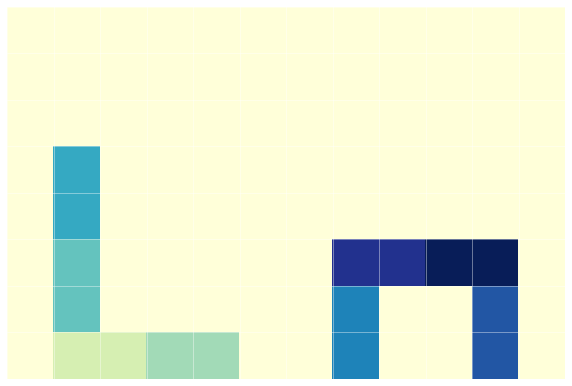

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
drawing.draw_from_actions_subplot(df_block[df_block.trialNum=='0'], 
                                  ax, 
                                  world_size = [12,8])

## Make basic visualizations and calculate descriptives

### Architect: mean number of words across trials

In [19]:
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_chat['trialNum'] = pd.to_numeric(df_chat['trialNum'], errors = 'coerce')

In [20]:
#Get sum of words for each trial, group by game then average across games
print(df_chat.groupby(['gameid','trialNum'])['word_count'].sum().groupby(['trialNum']).mean())

trialNum
0.0     59
1.0     44
2.0     22
3.0     20
4.0     13
5.0      9
6.0     11
7.0      7
8.0      7
9.0      4
10.0     7
11.0     8
Name: word_count, dtype: int64


Text(0, 0.5, 'Word Count')

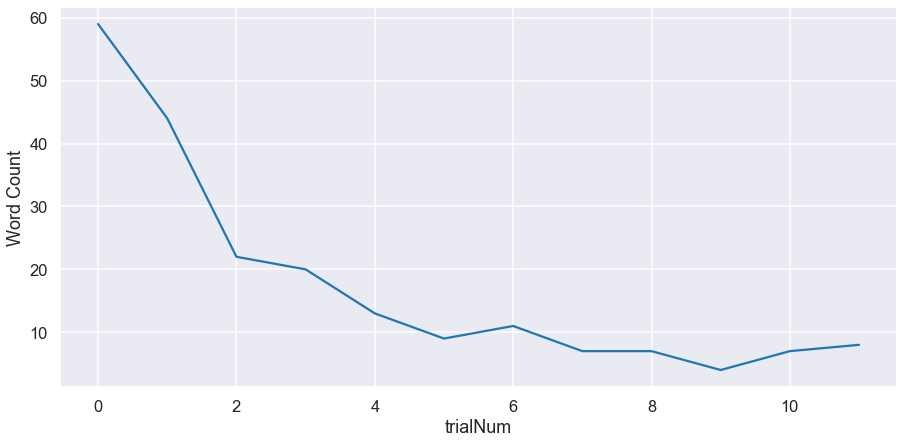

In [21]:
## line plots
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['word_count'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Word Count')

In [22]:
## print summary stat to console?

###  Architect: mean number of characters across trials

Text(0, 0.5, 'Char Count')

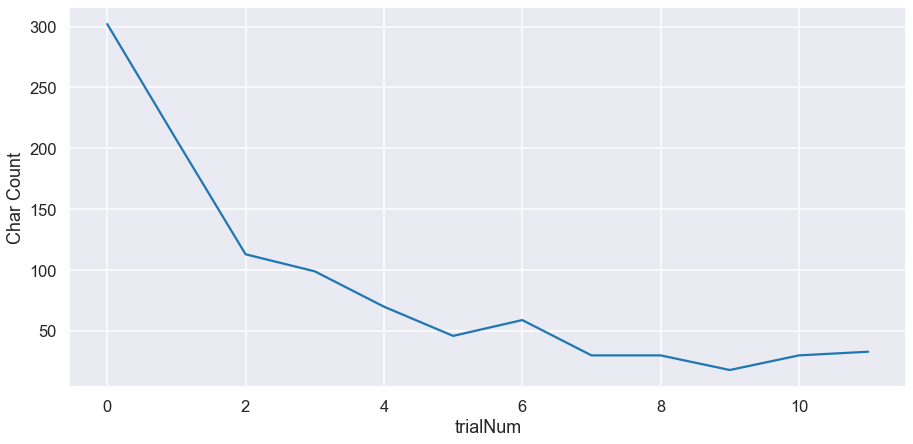

In [23]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['char_count'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Char Count')

### Architect: mean number of messages (across turns within a trial) across trials

Text(0, 0.5, 'Messages per trial')

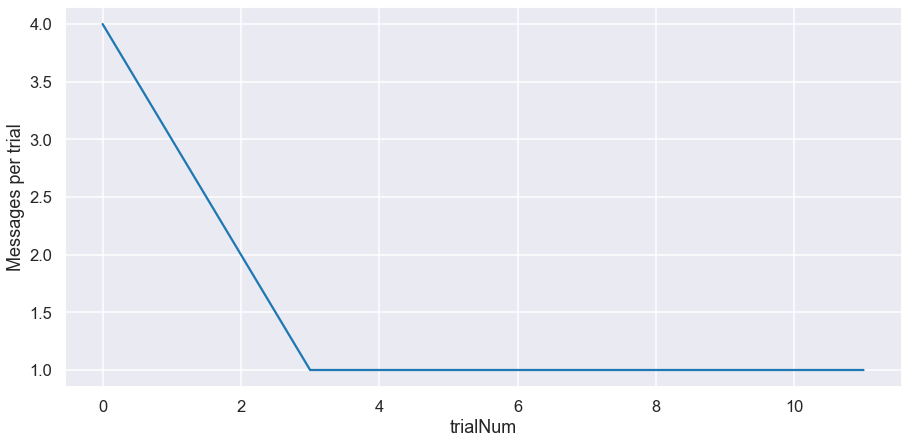

In [24]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['_id'].count().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Messages per trial')

### Architect: Total typing time (across turns within at trial) across trials

In [25]:
#check time elapsed
df_chat["timeElapsedInTurn"] = pd.to_numeric(df_chat['timeElapsedInTurn'])

Text(0, 0.5, 'Average Time elapsed, Architect')

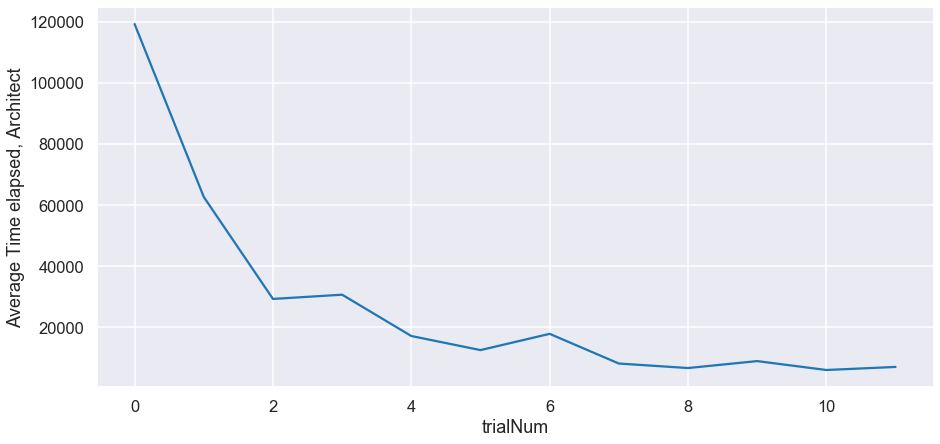

In [26]:
## line plots
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Average Time elapsed, Architect')

In [27]:
df_chat.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean()

trialNum
0.0     119268
1.0      62690
2.0      29315
3.0      30704
4.0      17183
5.0      12572
6.0      17894
7.0       8176
8.0       6702
9.0       8972
10.0      6058
11.0      7063
Name: timeElapsedInTurn, dtype: int64

### Builder: Reconstruction accuracy (intersection over union, IOU) across trials

In [28]:
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_trial['trialNum'] = pd.to_numeric(df_trial['trialNum'], errors = 'coerce')
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_block['trialNum'] = pd.to_numeric(df_block['trialNum'], errors = 'coerce')

Text(0, 0.5, 'Trial Score')

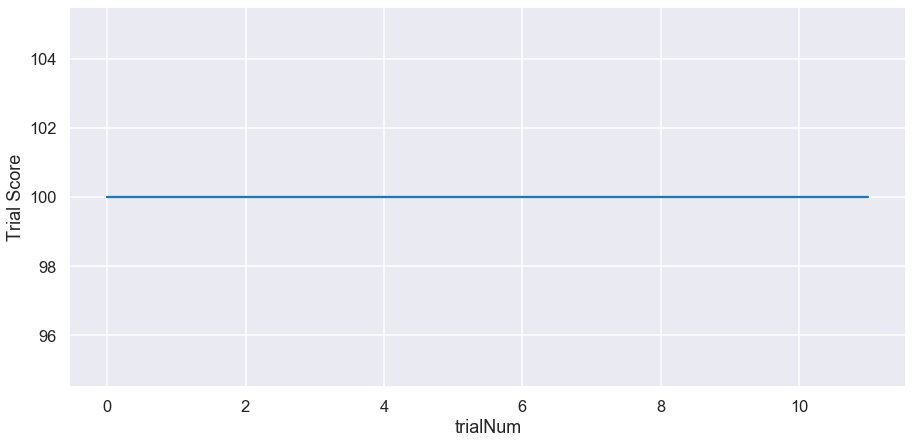

In [29]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['gameid','trialNum'])['score'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Trial Score')

### Builder: Mean number of block placements per utterance across trials

is this just 8/#utterances?

In [30]:
#TBD
#merge chat history (for number of messages) with block placement (for blocks placed)
print(df_chat.groupby(['gameid','trialNum'])['_id'].count())
print(df_block.groupby(['gameid','trialNum', 'turnNum'])['_id'].count())

gameid                                     trialNum
1560-7c8a5938-8ca4-4d37-8a0d-a600a04650ce  0.0         4
                                           1.0         3
                                           2.0         2
                                           3.0         1
                                           4.0         1
                                           5.0         1
                                           6.0         1
                                           7.0         1
                                           8.0         1
                                           9.0         1
                                           10.0        1
                                           11.0        1
Name: _id, dtype: int64
gameid                                     trialNum  turnNum
1560-7c8a5938-8ca4-4d37-8a0d-a600a04650ce  0.0       1          2
                                                     3          2
                                               

### Builder: Total reconstruction time (summed build time across turns, within each trial) across trials

In [31]:
#check time elapsed
df_block["timeElapsedInTurn"] = pd.to_numeric(df_block['timeElapsedInTurn'])

Text(0, 0.5, 'Average Time elapsed, Builder')

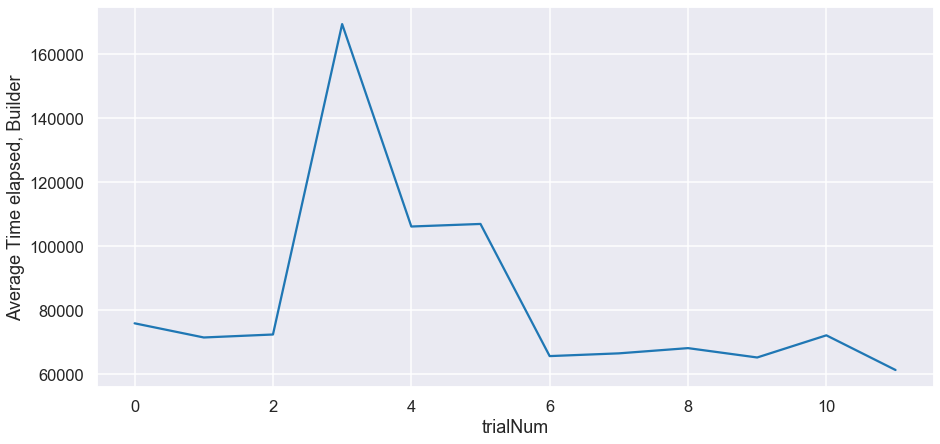

In [32]:
## line plots
fig, ax = plt.subplots(figsize=(15,7))
df_block.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Average Time elapsed, Builder')

### Now, let's look at the DVs above, w.r.t. repetition of scenes, IGNORING which side a tower appears on... so across four repetitions (where [A,B] is equivalent to [B,A])

In [33]:
#
def convert(list): 
    return tuple(i for i in list)
df_chat['targetSet'] = convert(df_chat[['leftTarget', 'rightTarget']].values.tolist())

In [34]:
df_chat.head(2)

,Unnamed: 0,_id,iterationName,gameid,time,assignmentId,leftTarget,rightTarget,trialNum,turnNum,repNum,content,timeElapsedInTurn,timeElapsedInTrial,eventType,word_count,char_count,targetSet
0,0,5ef3a6059bd44a067577f502,livetest0,1560-7c8a5938-8ca4-4d37-8a0d-a600a04650ce,1.593026e+12,33L7PJKHCKYV51US1KPA7UKWIPO8TH,vertical,horizontal,NaN,0,practice,Place the red domino to the left of the left t...,85734,85734,chatMessage,20,100,"(vertical, horizontal)"
1,1,5ef3a6399bd44a067577f506,livetest0,1560-7c8a5938-8ca4-4d37-8a0d-a600a04650ce,1.593026e+12,33L7PJKHCKYV51US1KPA7UKWIPO8TH,L,Pi,0.0,0,0,Place two blue dominos to left and right of le...,31497,31497,chatMessage,12,58,"(L, Pi)"


In [39]:
print(df_chat.groupby(['gameid','trialNum','targetSet'])['word_count'].sum())

gameid                                     trialNum  targetSet
1560-7c8a5938-8ca4-4d37-8a0d-a600a04650ce  0.0       (L, Pi)      59
                                           1.0       (L, C)       44
                                           2.0       (C, Pi)      22
                                           3.0       (L, C)       20
                                           4.0       (C, Pi)      13
                                           5.0       (L, Pi)       9
                                           6.0       (L, C)       11
                                           7.0       (L, Pi)       7
                                           8.0       (C, Pi)       7
                                           9.0       (C, Pi)       4
                                           10.0      (L, Pi)       7
                                           11.0      (L, C)        8
Name: word_count, dtype: int64


Text(0, 0.5, 'Words Per figure')

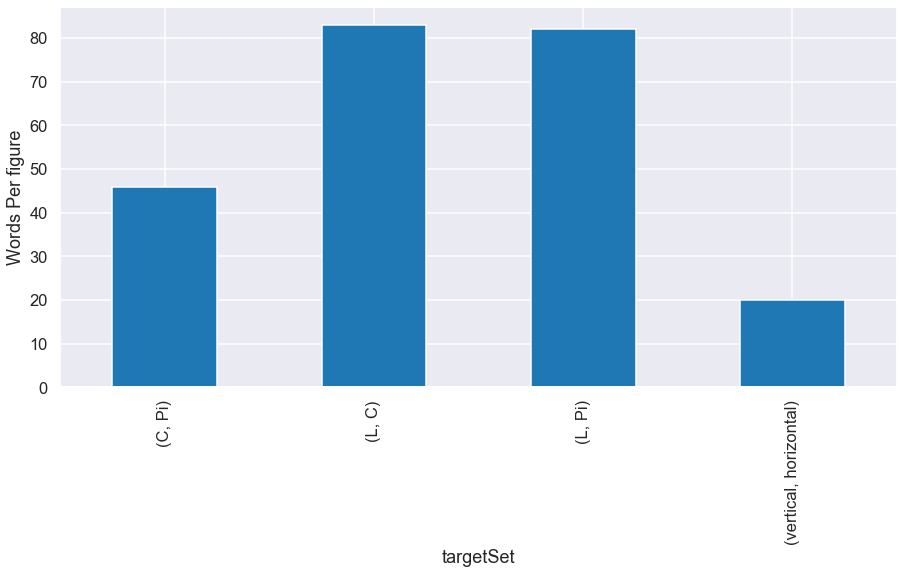

In [36]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','targetSet'])['word_count'].sum().groupby(['targetSet']).mean().plot.bar(ax = ax)
plt.ylabel('Words Per figure')